# ODEFormer experiment using SIR model

## Imports

In [3]:
import sys
import os

# Get the directory of the current notebook
notebook_dir = os.getcwd()

# Construct the path to the parent directory (where 'epidynax' is located)
parent_dir = os.path.join(notebook_dir, '..', '..') # Go up two levels to reach the 'epidynax' directory

# Add the parent directory to sys.path
sys.path.append(parent_dir)

In [4]:
from epidynax.data_generation import generate_noisy_sir_data
from odeformer_utils import get_odeformer_model, plot_actual_vs_estimated_trajectory, print_SIR_equations
import numpy as np
import matplotlib.pyplot as plt
from odeformer.metrics import r2_score, mean_squared_error

In [5]:
beam_size = 100
beam_temperature = 0.1

## Parameters of SIR model

In [6]:
days = 150
# Population size
init_S, init_I, init_R = 100, 2, 0
initial_conditions = [init_S, init_I, init_R]
# Population proportions
N = init_S + init_I + init_R
init_S_prop, init_I_prop, init_R_prop = init_S / N, init_I / N, init_R / N  
initial_conditions_prop = [init_S_prop, init_I_prop, init_R_prop]    
# Transmission and recovery rate
beta, gamma = 0.3, 0.1
times = np.arange(0, days, 1)
# Noise level
noise_level = 2
noise_prop = noise_level / N

In [7]:
# Solution when using population size
sol = generate_noisy_sir_data(initial_conditions, times, beta, gamma, proportion=False, noise_std=noise_level)

In [8]:
# Extract trajectory
S, I, R = sol.T
trajectory = np.stack([S, I, R], axis=1)

In [9]:
# Solution when using proportion
sol_prop = generate_noisy_sir_data(initial_conditions_prop, times, beta, gamma, proportion=True, noise_std=noise_prop)
# Extract trajectory
S_prop, I_prop, R_prop = sol_prop.T
trajectory_prop = np.stack([S_prop, I_prop, R_prop], axis=1)

## Determine the symbolic representation

### Raw population size model

In [10]:
# Load the pre-trained model

# class Params:
#     def __init__(self):
#         self.init_scale = N
#         self.time_range = days

# params = Params()
# Adding the params to the dstr object results in an additional ODE being generated?

dstr = get_odeformer_model(beam_temperature=beam_temperature, beam_size=beam_size)

Found pretrained model at odeformer.pt
Loaded pretrained model


In [ ]:
# Fit the model to the trajectory data for population size
candidates = dstr.fit(times, trajectory)
# Return the best symbolic expression
print_SIR_equations(dstr)

The true SIR model equations are:
\begin{align*} 
    \frac{dS}{dt} &= -\frac{\beta}{N}IS \\
    \frac{dI}{dt} &= \frac{\beta}{N}IS - \gamma I\\
    \frac{dR}{dt} &= \gamma I
\end{align*}
where $\beta=0.3$, $N=102$, and $\gamma=0.1$. Therefore $\frac{\beta}{N} \approx 0.002941$.

In [ ]:
# Predict the trajectory using the initial conditions and the fitted model (best candidate)
pred_trajectory = dstr.predict(times, trajectory[0])
print(r2_score(trajectory, pred_trajectory))
print(mean_squared_error(trajectory, pred_trajectory))

0.908984123329709
48.70032988053072


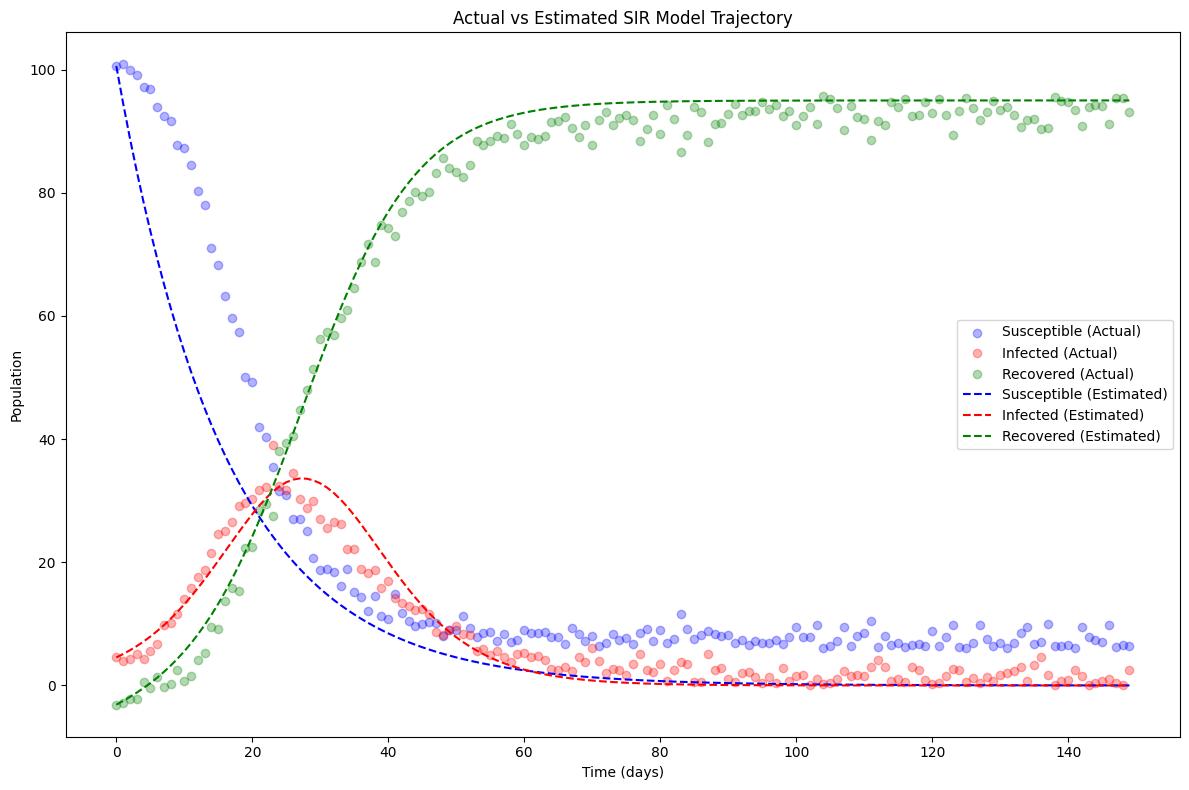

In [ ]:
fig = plot_actual_vs_estimated_trajectory(times, trajectory, pred_trajectory)
fig.show()

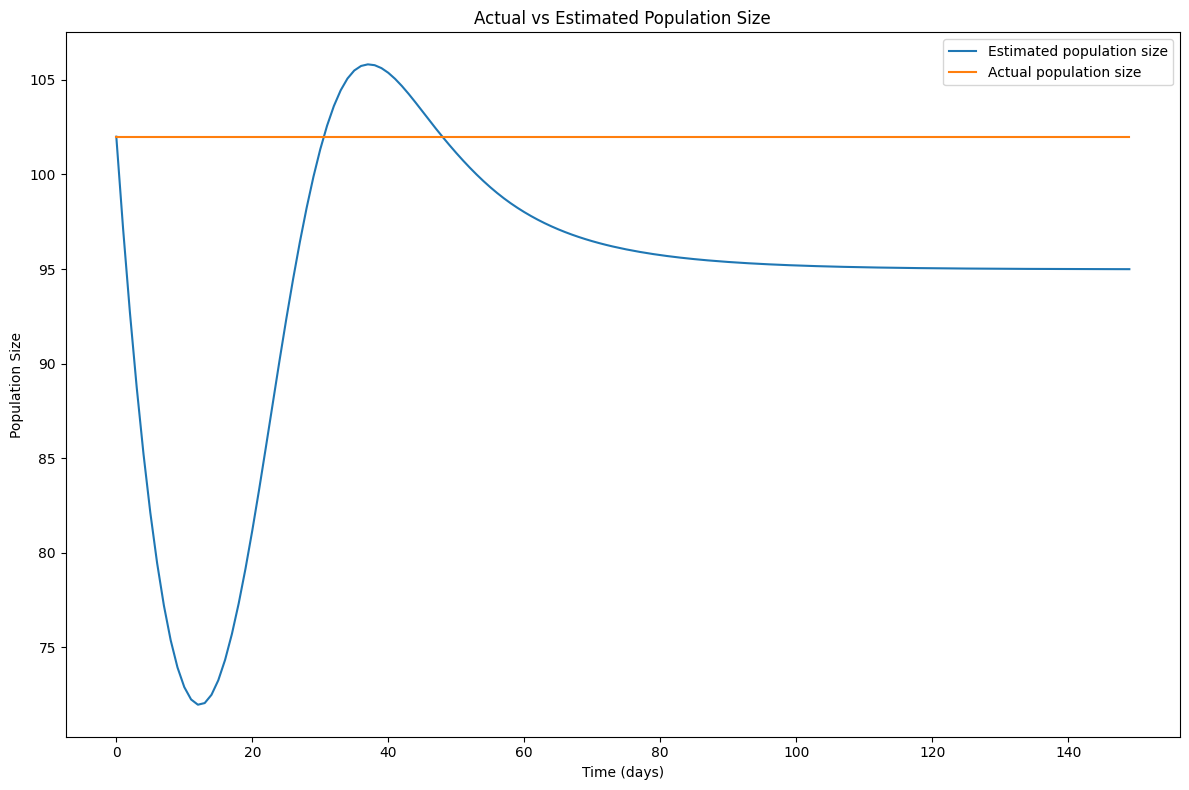

In [ ]:
# Check if the total population is conserved
plt.figure(figsize=(12, 8))
plt.plot(times, np.sum(pred_trajectory, axis=1), label='Estimated population size')
plt.plot(times, np.sum(trajectory, axis=1), label='Actual population size')
plt.xlabel('Time (days)')
plt.ylabel('Population Size')
plt.title('Actual vs Estimated Population Size')
plt.legend()
plt.tight_layout()
plt.show()

### Proportion SIR model

In [ ]:
# Retry using proportion=True

# Load the pre-trained model
# class Params:
#     def __init__(self):
#         self.init_scale = 1
#         self.time_range = days

# params = Params()

dstr_prop = get_odeformer_model(beam_temperature=beam_temperature, beam_size=beam_size)


Found pretrained model at odeformer.pt
Loaded pretrained model


In [ ]:
# Fit the model to the trajectory data for population proportion
candidates = dstr_prop.fit(times, trajectory_prop)
# Return the best symbolic expression
print_SIR_equations(dstr_prop)

S' = -0.0604 * S
I' = 0.1348 * I + -0.3203 * I * R
R' = 0.0013 * S + 0.0872 * I



The true SIR model equations are:
\begin{align*} 
    \frac{dS}{dt} &= -\beta IS \\
    \frac{dI}{dt} &= \beta IS - \gamma I\\
    \frac{dR}{dt} &= \gamma I
\end{align*}
where $\beta=0.3$, and $\gamma=0.1$.


In [ ]:
# Predict the trajectory using the initial conditions and the fitted model (best candidate)
pred_trajectory_prop = dstr_prop.predict(times, trajectory_prop[0])
print(r2_score(trajectory_prop, pred_trajectory_prop))
print(mean_squared_error(trajectory_prop, pred_trajectory_prop))

0.9205027146298183
0.004187492472616861


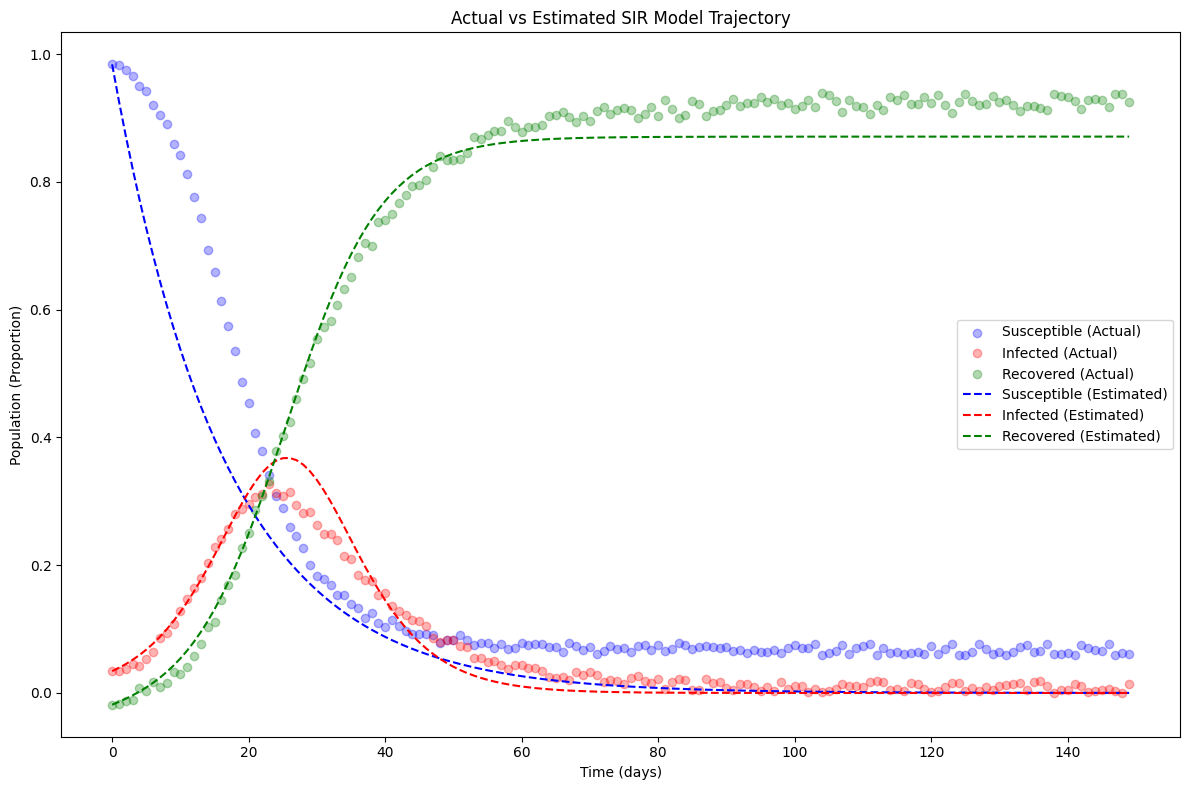

In [ ]:
fig = plot_actual_vs_estimated_trajectory(times, trajectory_prop, pred_trajectory_prop, ylabel='Population (Proportion)',)
fig.show()

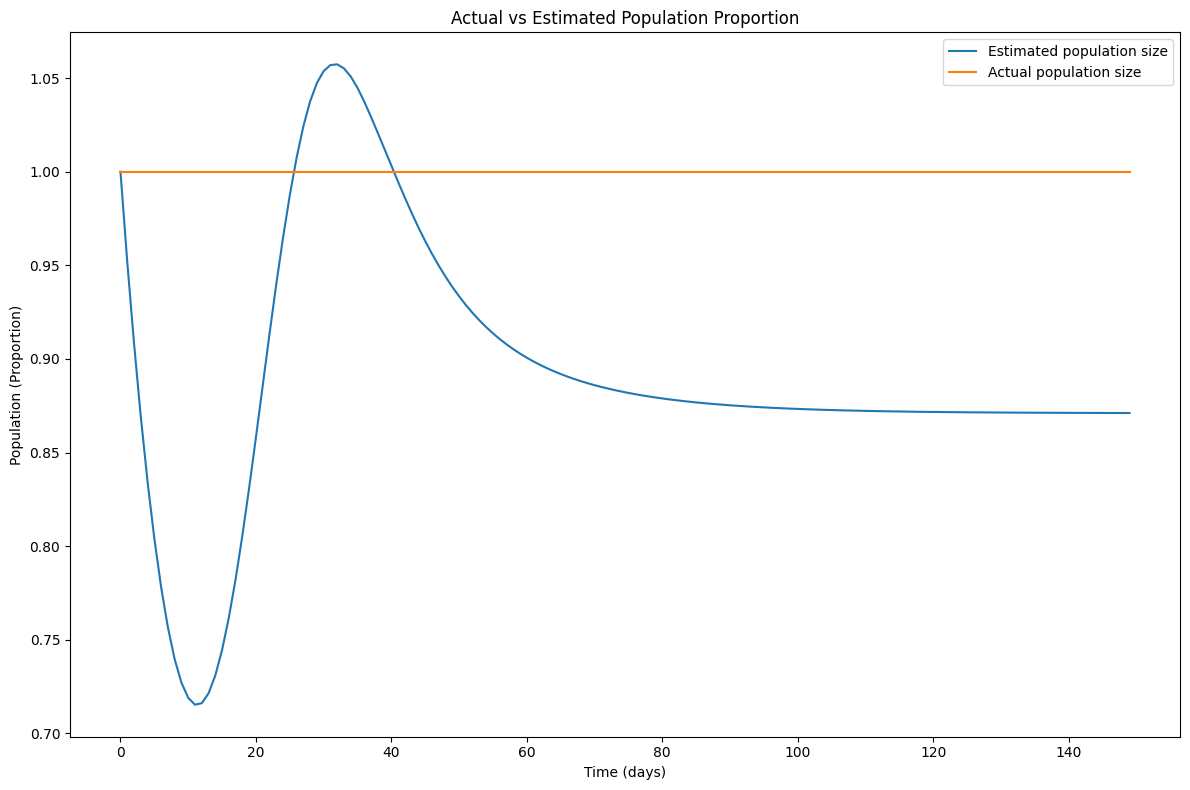

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(times, np.sum(pred_trajectory_prop, axis=1), label='Estimated population size')
plt.plot(times, np.sum(trajectory_prop, axis=1), label='Actual population size')
plt.xlabel('Time (days)')
plt.ylabel('Population (Proportion)')
plt.title('Actual vs Estimated Population Proportion')
plt.legend()
plt.tight_layout()
plt.show()